In [1]:
import json

In [2]:
annotations_file = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_mscoco_val2014_annotations.json"
questions_file = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_OpenEnded_mscoco_val2014_questions.json"

In [3]:
with open(annotations_file, 'rb') as f:
    annotations = json.load(f)

with open(questions_file, 'rb') as f:
    questions = json.load(f)

In [4]:
annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [5]:
questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [6]:
annotations

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:00:44'},
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'val2014',
 'annotations': [{'question_type': 'none of the above',
   'multiple_choice_answer': 'down',
   'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
    {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
    {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
    {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
    {'answer': 'down', 'answer_confidence': '

In [7]:
len(annotations['annotations'])

214354

In [9]:
unique_question_types = [x['question_type'] for x in annotations['annotations']]

In [10]:
set(unique_question_types)

{'are',
 'are the',
 'are there',
 'are there any',
 'are these',
 'are they',
 'can you',
 'could',
 'do',
 'do you',
 'does the',
 'does this',
 'has',
 'how',
 'how many',
 'how many people are',
 'how many people are in',
 'is',
 'is he',
 'is it',
 'is that a',
 'is the',
 'is the man',
 'is the person',
 'is the woman',
 'is there',
 'is there a',
 'is this',
 'is this a',
 'is this an',
 'is this person',
 'none of the above',
 'was',
 'what',
 'what animal is',
 'what are',
 'what are the',
 'what brand',
 'what color',
 'what color are the',
 'what color is',
 'what color is the',
 'what does the',
 'what is',
 'what is in the',
 'what is on the',
 'what is the',
 'what is the color of the',
 'what is the man',
 'what is the name',
 'what is the person',
 'what is the woman',
 'what is this',
 'what kind of',
 'what number is',
 'what room is',
 'what sport is',
 'what time',
 'what type of',
 'where are the',
 'where is the',
 'which',
 'who is',
 'why',
 'why is the'}

In [8]:
annotations['annotations'][2]

{'question_type': 'what is',
 'multiple_choice_answer': 'picnic table',
 'answers': [{'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'picnic table', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 262148,
 'answer_type': 'other',
 'question_id': 262148002}

In [15]:
questions['questions'][0]

{'image_id': 262148,
 'question': 'Where is he looking?',
 'question_id': 262148000}

In [ ]:
train_image_dir_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/train2017"
# http://images.cocodataset.org/zips/val2014.zip
# /scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/val2014/COCO_val2014_000000262148.jpg

In [3]:
import json
import os

from PIL import Image
from torch.utils.data import Dataset

In [15]:
class VQADataset(Dataset):
    def __init__(
        self, image_dir_path, question_path, annotations_path, is_train, dataset_name, take_unique_image=True
    ):
        self.questions = json.load(open(question_path, "r"))["questions"]
        if annotations_path is not None:
            self.answers = json.load(open(annotations_path, "r"))["annotations"]
        else:
            self.answers = None
        self.image_dir_path = image_dir_path
        self.is_train = is_train
        self.dataset_name = dataset_name
        if self.dataset_name in {"vqav2", "ok_vqa"}:
            self.img_coco_split = self.image_dir_path.strip("/").split("/")[-1]
            assert self.img_coco_split in {"train2014", "val2014", "test2015"}
        if take_unique_image:
            seen_image_ids = set()
            questions = []
            answers = []
            for question, answer in zip(self.questions,self.answers):
                if question["image_id"] not in seen_image_ids:
                    seen_image_ids.add(question["image_id"])
                    questions.append(question)
                    answers.append(answer)
            self.questions = questions
            self.answers = answers
    def __len__(self):
        return len(self.questions)

    def get_img_path(self, question):
        if self.dataset_name in {"vqav2", "ok_vqa"}:
            return os.path.join(
                self.image_dir_path,
                f"COCO_{self.img_coco_split}_{question['image_id']:012d}.jpg"
                if self.is_train
                else f"COCO_{self.img_coco_split}_{question['image_id']:012d}.jpg",
            )
        elif self.dataset_name == "vizwiz":
            return os.path.join(self.image_dir_path, question["image_id"])
        elif self.dataset_name == "textvqa":
            return os.path.join(self.image_dir_path, f"{question['image_id']}.jpg")
        else:
            raise Exception(f"Unknown VQA dataset {self.dataset_name}")

    def __getitem__(self, idx):
        question = self.questions[idx]
        img_path = self.get_img_path(question)
        image = Image.open(img_path)
        image.load()
        results = {
            "image": image,
            "question": question["question"],
            "question_id": question["question_id"],
        }
        if self.answers is not None:
            answers = self.answers[idx]
            results["answers"] = [a["answer"] for a in answers["answers"]]
        return results

In [16]:
image_dir_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/val2014"
questions_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_OpenEnded_mscoco_val2014_questions.json"
annotations_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_mscoco_val2014_annotations.json"
vqa_dataset = VQADataset(image_dir_path, questions_path, annotations_path,True, "vqav2")

In [18]:
vqa_dataset = VQADataset(image_dir_path, questions_path, annotations_path,True, "vqav2",False)

In [21]:
len(vqa_dataset)

82783

In [19]:
len(vqa_dataset)

214354

In [20]:
image_dir_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/train2014"
questions_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_OpenEnded_mscoco_train2014_questions.json"
annotations_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_mscoco_train2014_annotations.json"
vqa_dataset = VQADataset(image_dir_path, questions_path, annotations_path,True, "vqav2")

In [22]:
vqa_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'question': 'What is this photo taken looking through?',
 'question_id': 458752000,
 'answers': ['net',
  'net',
  'net',
  'netting',
  'net',
  'net',
  'mesh',
  'net',
  'net',
  'net']}

In [25]:
vqa_dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640>,
 'question': 'What color is the snow?',
 'question_id': 262146000,
 'answers': ['white',
  'white',
  'white',
  'white',
  'white',
  'white',
  'white',
  'white',
  'white',
  'white']}

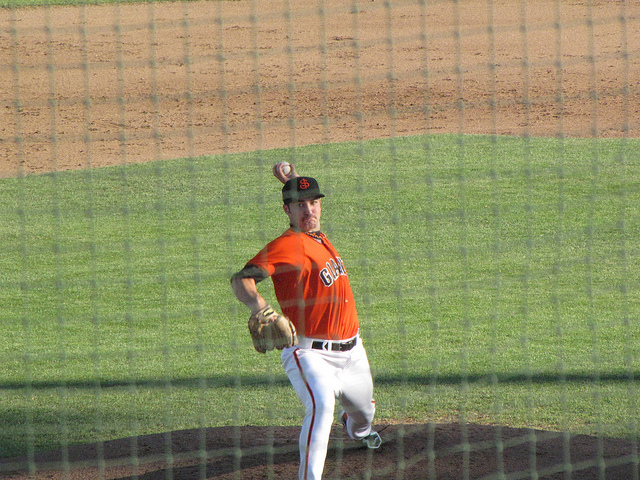

In [23]:
vqa_dataset[0]['image']

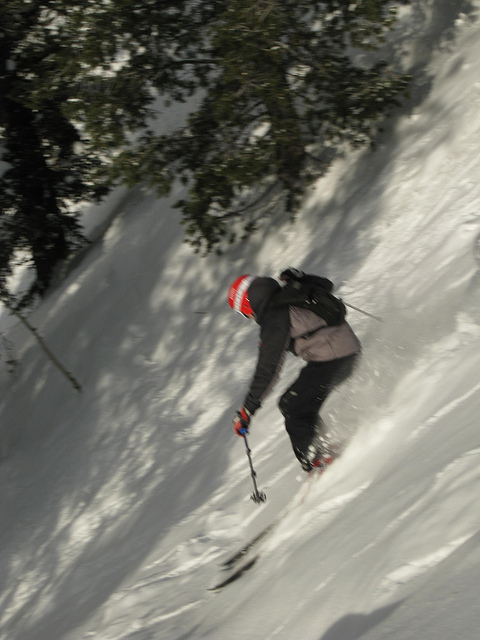

In [24]:
vqa_dataset[1]['image']